In [1]:
%run Function_set_dic.ipynb
import networkx as nx
import numpy as np
from collections import defaultdict
import random
from numpy import random
import matplotlib.pyplot as plt

In [2]:
from collections import defaultdict

from dwave.system.samplers import DWaveSampler
from dwave.system.composites import EmbeddingComposite
import networkx as nx
import numpy as np
import dwave.inspector
import dimod
from dwave.system import LeapHybridSampler
import matplotlib
from matplotlib import pyplot as plt
import pandas as pd

In [3]:
network,pos = Make_Question(4,4,Density = 0.85, option = "1-norm", distance = 2)

print(network)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0.]]


{(1, 0): '0', (2, 0): '1', (3, 0): '2', (4, 0): '3', (5, 0): '4', (6, 0): '5', (7, 0): '6', (8, 0): '7', (9, 0): '8', (10, 0): '9', (11, 0): '10', (12, 0): '11', (13, 0): '12', (1, 2): '13', (1, 4): '14', (2, 5): '16', (3, 4): '17', (3, 7): '18', (4, 5): '21', (4, 8): '22', (5, 6): '25', (5, 9): '26', (6, 10): '28', (7, 8): '30', (8, 9): '33', (8, 11): '34', (9, 10): '37', (9, 12): '38', (10, 13): '41', (11, 12): '43', (12, 13): '46', (2, 1): '15', (4, 1): '19', (4, 3): '20', (5, 2): '23', (5, 4): '24', (6, 5): '27', (7, 3): '29', (8, 4): '31', (8, 7): '32', (9, 5): '35', (9, 8): '36', (10, 6): '39', (10, 9): '40', (11, 8): '42', (12, 9): '44', (12, 11): '45', (13, 10): '47', (13, 12): '48'}


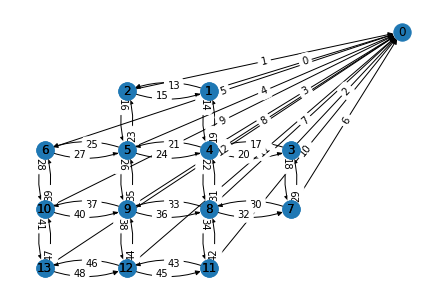

In [4]:
G, compelete_label, graph = complete_Graph(network,pos)
print(compelete_label)

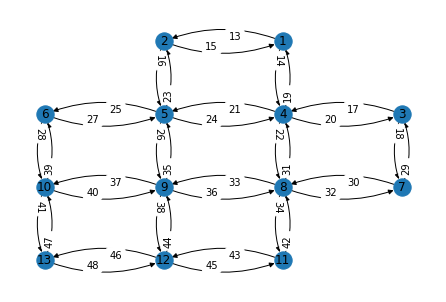

In [5]:
G_prime, sub_edge_label, sub_graph = sub_Graph (network,pos)

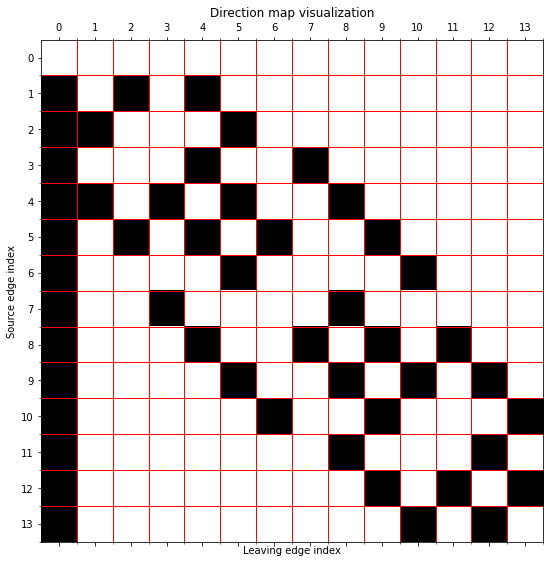

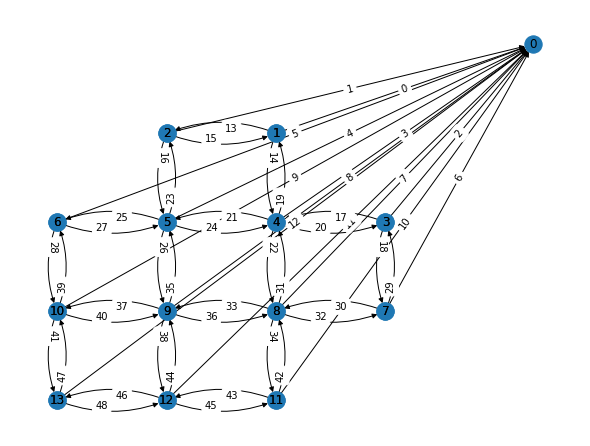

In [6]:
#matfig = plt.figure(figsize=(Final_map.shape[0],Final_map.shape[1]))
matfig = plt.figure(figsize=(9,9))
plt.matshow(network,cmap=plt.cm.binary,fignum=matfig.number)
ax = plt.gca()
#plt.matshow(Final_map,cmap=plt.cm.binary)
plt.xlabel('Leaving edge index')
plt.ylabel('Source edge index')
plt.title ("Direction map visualization")

# Major ticks
ax.set_xticks(np.arange(0, network.shape[0], step=1))
ax.set_yticks(np.arange(0, network.shape[0], step=1))

# Labels for major ticks
ax.set_xticklabels(np.arange(0, network.shape[0], step=1))
ax.set_yticklabels(np.arange(0, network.shape[0], step=1))

# Minor ticks
ax.set_xticks(np.arange(0.5, network.shape[0]+0.5, step=1), minor=True)
ax.set_yticks(np.arange(0.5, network.shape[0]+0.5, step=1), minor=True)

# Gridlines based on minor ticks
ax.grid(which='minor', color='r', linestyle='-', linewidth=1)

plt.show()


plt.figure(2,figsize=(8,6)) 
_, _, _ = complete_Graph(network,pos)

In [7]:
%run Function_set_dic.ipynb
# How many panel ---> Max electricity level wire could reach 
Q = len(pos)-1

N_tree = capacity_subtree_limit_generator(pos,Q)

5 11


In [83]:
%run Function_set_dic.ipynb

print(Q)

# How many edges
edge_number = len(compelete_label)


# basic_cost shape => (1,number_of_edge)
# such as : basic_cost = np.vstack(np.ones(number_of_edge))
# test case : #basic_cost = np.arange(edge_number)

basic_cost = np.ones(edge_number) * 2


# flow cost (p)
flow_cost = np.ones(edge_number) 
p = 1


# make dictionary
edge_dictionary, Total = make_dictionary(edge_number, Q, N_tree)

# initialize a QUBO matrix needed
QUBO_matrix_initial = np.zeros((Total, Total))


print('N_tree  = ', N_tree )
#print('edge_dictionary  = ', edge_dictionary )

13
N_tree  =  [ 6  7  8  9 10 11]


In [114]:
s = [dimod.Binary(f's_{j}') for j in range(len(N_tree))]
x = [dimod.Binary(f'x_{i}') for i in range(edge_number * Q)]

#print(s)
#print(x)

In [115]:
cqm = dimod.ConstrainedQuadraticModel()
#print(edge_dictionary)

In [116]:
# find term 1
index_1=[]

index_2=[]

for edge in range(edge_number):
    for level in range(Q):
        #print(level,edge)
        index_1.append(edge_dictionary['x_%d_%d'%(edge,level + 1)])

for edge in range(Q , edge_number):
    for level in range(Q):
        #print(level,edge)
        index_2.append(edge_dictionary['x_%d_%d'%(edge,level + 1)])

c_e = (np.tile(np.vstack(basic_cost),(1,Q))).flatten()
        
level_coeff = (np.tile(np.arange(Q),(edge_number,1))).flatten()

print(np.shape(c_e))
        
cqm.set_objective(sum(s) * (sum(c_e[i] * x[i] for i in index_1) + p * sum(c_e[j] * (level_coeff [j] - 1) * x[j] for j in index_2 ) ) )

(637,)


In [117]:
def constraint_1(Final_map, Q, edge_dictionary, compelete_label, vertex):
    
    index = np.hstack(np.asarray(np.where(Final_map[vertex,:])))             
            
    index_matched = []
    
    for vertex_selected in index:
            
        #print(int(compelete_label[(vertex, vertex_selected)]))
            
        for level in range(Q):
            index_matched.append(edge_dictionary['x_%d_%d'%( int(compelete_label[(vertex, vertex_selected)]), level + 1)])
    
    return index_matched


In [118]:
## C 1

for vertex in range(1, Q + 1):
    
    index = constraint_1(network, Q, edge_dictionary, compelete_label, vertex)
    
    cqm.add_constraint( sum(x[i] for i in index) == 1, label=f'contraint_1_vertex_{vertex}')

In [119]:
def constraint_2(Final_map, Q, edge_dictionary, compelete_label, vertex):
    
    index_out = np.hstack(np.asarray(np.where(Final_map[vertex,:])))             
            
    index_out_matched = []
    
    for vertex_selected in index_out:
            
        for level in range(Q):
            index_out_matched.append(edge_dictionary['x_%d_%d'%( int(compelete_label[(vertex, vertex_selected)]), level + 1)])
    
    index_in = np.hstack(np.asarray(np.where(Final_map[:,vertex])))
    
    index_in_matched = []
    
    for vertex_selected in index_in:
            
        for level in range(Q):
            index_in_matched.append(edge_dictionary['x_%d_%d'%( int(compelete_label[(vertex, vertex_selected)]), level + 1)])

    
    return index_out_matched, index_in_matched

In [120]:
## C 2

for vertex in range(1, Q + 1):
    
    index_out, index_in = constraint_2(network, Q, edge_dictionary, compelete_label, vertex)
    
    cqm.add_constraint( sum(level_coeff[i]*x[i] for i in index_out) - sum(level_coeff[j]*x[j] for j in index_in)  == 1, label=f'contraint_2_vertex_{vertex}')

In [121]:
def constraint_4(Q, edge_dictionary, Total, N_k):
    
    index_option_matched = []
                 
    index_bus_matched = []
    
    #print(index_option_matched)
    
    for option_num, option in enumerate(N_k):
                 
        index_option_matched.append(edge_dictionary["x_tree_%d"%(option_num)])
                 

    for Bus_edge in range(Q):         

        for level in range(Q):
                    
            index_bus_matched.append(edge_dictionary['x_%d_%d'%(Bus_edge, level + 1)])
                   
    return index_option_matched, index_bus_matched 
                 

In [122]:
#C 4

index_option, index_bus = constraint_4(Q, edge_dictionary, Total, N_tree)

cqm.add_constraint( sum(x[j] for j in index_bus) - sum( coeff * s[i] for  i, coeff in enumerate(N_tree) ) == 0, label=f'contraint_4')

'contraint_4'

In [123]:
#
cqm.add_constraint( sum(s) == 1, label=f'contraint_5')

'contraint_5'

In [124]:
from dwave.system import LeapHybridCQMSampler
sampler = LeapHybridCQMSampler()    
print(sampler.solver.name)

hybrid_constrained_quadratic_model_version1


In [125]:
#sampleset = sampler.sample_cqm(cqm, time_limit=60, label="SDK Examples - Solar Panel Strategy")

sampleset = sampler.sample_cqm(cqm, label="SDK Examples - Solar Panel Strategy")


In [134]:
print(cqm)
#print(cqm.__dict__)
a = getattr(cqm,'_constraints')
print(getattr(cqm,'_constraints'))

{'contraint_1_vertex_1': BinaryQuadraticModel({'x_0': 1.0, 'x_1': 1.0, 'x_2': 1.0, 'x_3': 1.0, 'x_4': 1.0, 'x_5': 1.0, 'x_6': 1.0, 'x_7': 1.0, 'x_8': 1.0, 'x_9': 1.0, 'x_10': 1.0, 'x_11': 1.0, 'x_12': 1.0, 'x_169': 1.0, 'x_170': 1.0, 'x_171': 1.0, 'x_172': 1.0, 'x_173': 1.0, 'x_174': 1.0, 'x_175': 1.0, 'x_176': 1.0, 'x_177': 1.0, 'x_178': 1.0, 'x_179': 1.0, 'x_180': 1.0, 'x_181': 1.0, 'x_182': 1.0, 'x_183': 1.0, 'x_184': 1.0, 'x_185': 1.0, 'x_186': 1.0, 'x_187': 1.0, 'x_188': 1.0, 'x_189': 1.0, 'x_190': 1.0, 'x_191': 1.0, 'x_192': 1.0, 'x_193': 1.0, 'x_194': 1.0}, {}, 0.0, 'BINARY') == 1, 'contraint_1_vertex_2': BinaryQuadraticModel({'x_13': 1.0, 'x_14': 1.0, 'x_15': 1.0, 'x_16': 1.0, 'x_17': 1.0, 'x_18': 1.0, 'x_19': 1.0, 'x_20': 1.0, 'x_21': 1.0, 'x_22': 1.0, 'x_23': 1.0, 'x_24': 1.0, 'x_25': 1.0, 'x_195': 1.0, 'x_196': 1.0, 'x_197': 1.0, 'x_198': 1.0, 'x_199': 1.0, 'x_200': 1.0, 'x_201': 1.0, 'x_202': 1.0, 'x_203': 1.0, 'x_204': 1.0, 'x_205': 1.0, 'x_206': 1.0, 'x_207': 1.0, 'x_208'

In [127]:
def parse_best(sampleset):
    best = sampleset.filter(lambda row: row.is_feasible).first
    s = [val for key, val in best.sample.items() if "s_" in key]
    x = [val for key, val in best.sample.items() if "x_" in key]
    result = x + s
    
    return result.astype(int), best

In [128]:
final_index, _ = parse_best(sampleset)  

for value in final_index:
    #print(str(value//Q))
    final_G.add_weighted_edges_from([(*edge, value % Q + 1) for edge, label in compelete_label.items() if label == str(value//Q)])
    
matfig = plt.figure(figsize=(10,10)) 
labels = nx.get_edge_attributes(final_G,'weight')
widths = list(nx.get_edge_attributes(final_G,'weight').values())
print("widths",widths)
nx.draw_networkx(final_G, pos)
nx.draw_networkx_edge_labels(final_G,pos,edge_labels = labels)
nx.draw_networkx_edges(final_G,pos,width = widths)

ValueError: SampleSet is empty